
# Tutorial 02 - Differential Power Analysis

Let's first import some useful libraries. You can add other libraries below if you want to use something else!

In [35]:
# Import some useful libraries
from scipy.stats import pearsonr 
import numpy as np
import matplotlib.pyplot as plt
import chipwhisperer as cw
from tqdm.notebook import tnrange
from collections import deque
import os
from random import randrange
from tqdm import trange
from time import sleep
%matplotlib inline

## 1 - Getting traces for attacking the TinyAES implementation

The target of our attack is a software [AES](https://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.197.pdf) implementation that can be found on the [ChipWhisperer Github page](https://github.com/newaetech/chipwhisperer).

To attack this implementation, we need to have the power traces of the chip while executing this AES implementation. For this tutorial, there are two options:
1) Collect your own traces with ChipWhisperer. See Tutorial 01 on how to collect your own traces.
2) Load in existing traces. These traces are available on Brightspace. 

Feel free to try out both options!


### 1.1 - Collecting Traces with ChipWhisperer

The first task is to generate traces using Chipwhisperer. Collect 2500 traces for TinyAES. Each trace should have 4000 samples. 
Save the traces that you collected along with the corresponding plaintexts and keys. 

In [36]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
CRYPTO_TARGET = 'TINYAES128C'

In [37]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET"
#cd /{address to the chipwhisperer directory}/firmware/mcu/simpleserial-aes
cd ../chipwhisperer/firmware/mcu/simpleserial-aes
make PLATFORM=$1 CRYPTO_TARGET=$2

Building for platform CWLITEARM with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (Arm GNU Toolchain 15.2.Rel1 (Build arm-15.86)) 15.2.1 20251203
Copyright (C) 2025 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

mkdir -p objdir-CWLITEARM 
.
Compiling:
-en     simpleserial-aes.c ...
-e Done!
.
Compiling:
-en     .././simpleserial/simpleserial.c ...
-e Done!
.
Compiling:
-en     .././hal/hal.c ...
-e Done!
.
Compiling:
-en     .././hal//stm32f3/stm32f3_hal.c ...
-e Done!
.
Compiling:
-en     .././hal//stm32f3/stm32f3_hal_lowlevel.c ...
-e Done!
.
Compiling:
-en     .././hal//stm32f3/stm32f3_sysmem.c ...
-e Done!
.
Compiling:
-en     .././crypto/tiny-AES128-C/aes.c ...
-e Done!
.
Compiling:
-en     .././cryp

/Applications/ArmGNUToolchain/15.2.rel1/arm-none-eabi/bin/../lib/gcc/arm-none-eabi/15.2.1/../../../../arm-none-eabi/bin/ld: warning: simpleserial-aes-CWLITEARM.elf has a LOAD segment with RWX permissions


Memory region         Used Size  Region Size  %age Used
             RAM:        2416 B        40 KB      5.90%
             ROM:        6312 B       256 KB      2.41%
-e Done!
.
Creating load file for Flash: simpleserial-aes-CWLITEARM.hex
arm-none-eabi-objcopy -O ihex -R .eeprom -R .fuse -R .lock -R .signature simpleserial-aes-CWLITEARM.elf simpleserial-aes-CWLITEARM.hex
.
Creating load file for Flash: simpleserial-aes-CWLITEARM.bin
arm-none-eabi-objcopy -O binary -R .eeprom -R .fuse -R .lock -R .signature simpleserial-aes-CWLITEARM.elf simpleserial-aes-CWLITEARM.bin
.
Creating load file for EEPROM: simpleserial-aes-CWLITEARM.eep
arm-none-eabi-objcopy -j .eeprom --set-section-flags=.eeprom="alloc,load" \
	--change-section-lma .eeprom=0 --no-change-warnings -O ihex simpleserial-aes-CWLITEARM.elf simpleserial-aes-CWLITEARM.eep || exit 0
.
Creating Extended Listing: simpleserial-aes-CWLITEARM.lss
arm-none-eabi-objdump -h -S -z simpleserial-aes-CWLITEARM.elf > simpleserial-aes-CWLITEARM.l

In [39]:
scope = cw.scope()
print(scope)


cwlite Device
sn         = 50203220343043543130392036313033
fw_version = 
    major = 0
    minor = 62
    debug = 0
gain = 
    mode = low
    gain = 0
    db   = 5.5
adc = 
    state          = False
    basic_mode     = low
    timeout        = 2
    offset         = 0
    presamples     = 0
    samples        = 24400
    decimate       = 1
    trig_count     = 14240228
    fifo_fill_mode = normal
clock = 
    adc_src       = clkgen_x1
    adc_phase     = 0
    adc_freq      = 0
    adc_rate      = 0.0
    adc_locked    = True
    freq_ctr      = 0
    freq_ctr_src  = extclk
    clkgen_src    = system
    extclk_freq   = 10000000
    clkgen_mul    = 2
    clkgen_div    = 1
    clkgen_freq   = 192000000.0
    clkgen_locked = True
trigger = 
    triggers = tio4
    module   = basic
io = 
    tio1         = serial_tx
    tio2         = serial_rx
    tio3         = high_z
    tio4         = high_z
    pdid         = high_z
    pdic         = high_z
    nrst         = high_z
    glitch_h

In [40]:
if __name__=="__main__":
    programmer = cw.SAMFWLoader(scope=None)
    # programmer.program("/dev/ttyACM0", hardware_type='cwlite')

In [41]:
prog = cw.SAMFWLoader(scope)
prog.auto_program()

Entering bootloader mode...
Detected com port /dev/cu.usbmodem101
Loading cwlite firmware...
Opened!
Connecting...
Connected!
Erasing...
Erased!
Programming file SAM3U_CW1173.bin...
Programmed!
Verifying...
Verify OK!
Resetting...
Upgrade successful


In [42]:
scope = cw.scope()
print(scope)
sleep(2)

cwlite Device
sn         = 50203220343043543130392036313033
fw_version = 
    major = 0
    minor = 62
    debug = 0
gain = 
    mode = low
    gain = 0
    db   = 5.5
adc = 
    state          = False
    basic_mode     = low
    timeout        = 2
    offset         = 0
    presamples     = 0
    samples        = 24400
    decimate       = 1
    trig_count     = 14479439
    fifo_fill_mode = normal
clock = 
    adc_src       = clkgen_x1
    adc_phase     = 0
    adc_freq      = 0
    adc_rate      = 0.0
    adc_locked    = True
    freq_ctr      = 0
    freq_ctr_src  = extclk
    clkgen_src    = system
    extclk_freq   = 10000000
    clkgen_mul    = 2
    clkgen_div    = 1
    clkgen_freq   = 192000000.0
    clkgen_locked = True
trigger = 
    triggers = tio4
    module   = basic
io = 
    tio1         = serial_tx
    tio2         = serial_rx
    tio3         = high_z
    tio4         = high_z
    pdid         = high_z
    pdic         = high_z
    nrst         = high_z
    glitch_h

In [43]:
scope.default_setup()
print(scope)

cwlite Device
sn         = 50203220343043543130392036313033
fw_version = 
    major = 0
    minor = 62
    debug = 0
gain = 
    mode = high
    gain = 30
    db   = 24.8359375
adc = 
    state          = False
    basic_mode     = rising_edge
    timeout        = 2
    offset         = 0
    presamples     = 0
    samples        = 5000
    decimate       = 1
    trig_count     = 734254718
    fifo_fill_mode = normal
clock = 
    adc_src       = clkgen_x4
    adc_phase     = 0
    adc_freq      = 11376365
    adc_rate      = 11376365.0
    adc_locked    = True
    freq_ctr      = 0
    freq_ctr_src  = extclk
    clkgen_src    = system
    extclk_freq   = 10000000
    clkgen_mul    = 2
    clkgen_div    = 26
    clkgen_freq   = 7384615.384615385
    clkgen_locked = True
trigger = 
    triggers = tio4
    module   = basic
io = 
    tio1         = serial_rx
    tio2         = serial_tx
    tio3         = high_z
    tio4         = high_z
    pdid         = high_z
    pdic         = high_z


In [ ]:
target = cw.target(scope, cw.targets.SimpleSerial)


In [45]:
fw_path = "../chipwhisperer/firmware/mcu/simpleserial-aes/simpleserial-aes-{}.hex".format(PLATFORM)


In [46]:
prog = cw.programmers.STM32FProgrammer

In [47]:
cw.program_target(scope, prog, fw_path)

Detected unknown STM32F ID: 0x446
Extended erase (0x44), this can take ten seconds or more
Attempting to program 6311 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 6311 bytes


In [ ]:
nr_traces = 2500
nr_samples = 4000
traces = []

from chipwhisperer.common.utils import util
bytearray = util.bytearray # type: ignore

scope.adc.samples = nr_samples

""" 
- generate key
- for 2500
    - generate random plaintext
    - scope 4000 samples
"""
key = bytearray(os.urandom(16))
traces = []

for i in trange(nr_traces, desc='Capturing traces'):
    text = bytearray(os.urandom(16))

    trace = cw.capture_trace(scope, target, text, key)

    if trace is None:
        raise Exception
    
    traces.append(trace)


# Save your traces to disk
trace_array = np.array([trace.wave for trace in traces])
textin_array = np.array([trace.textin for trace in traces])
known_keys = np.array([trace.key for trace in traces])  # for fixed key, these keys are all the same


Capturing traces: 100%|██████████| 2500/2500 [04:01<00:00, 10.37it/s]


In [49]:
file_for_arrays = open("tutorial2_arrays.npz", "wb") 
np.savez(file_for_arrays, traces=trace_array, plaintexts=textin_array, keys=known_keys)
file_for_arrays.close()

### 1.2 - Load existing traces (in case you could not collect traces from ChipWhisperer)
If you cannot finish the tutorial here, you have the traces to work on later at home. 
If you cannot collect traces with Chipwhisperer for some reason, or you forgot to save the collected traces and you want to finish the tutorial at home, you can download some sample traces from Brightspace. 

Let's load the traces. It can be either be the traces you generated or the traces in the link. We are also going to print the keys, so we can later check if we have recovered the correct key!

In [300]:
#### Code to load the traces provided on Brightspace
tutorial2_arrays = open("tutorial2_arrays.npz", "rb")
measurements = np.load(tutorial2_arrays)

traces = measurements["traces"]
print("traces = ", traces.shape)
nr_traces, nr_samples = traces.shape
print(nr_traces, nr_samples)

plaintexts = measurements["plaintexts"]
print("plaintexts = ", plaintexts.shape)

keys = measurements["keys"]
print("keys = ", keys.shape)

print("For every power trace/plaintext combination, we use the same key: \n" + str(keys))
correct_key = keys[0]

traces =  (2500, 5000)
2500 5000
plaintexts =  (2500, 16)
keys =  (2500, 16)
For every power trace/plaintext combination, we use the same key: 
[[ 98   1 132 ...  15 210  53]
 [ 98   1 132 ...  15 210  53]
 [ 98   1 132 ...  15 210  53]
 ...
 [ 98   1 132 ...  15 210  53]
 [ 98   1 132 ...  15 210  53]
 [ 98   1 132 ...  15 210  53]]


In [66]:
correct_key

array([ 98,   1, 132,  82,  48, 200,  76, 179,  58, 191,  49, 193, 143,
        15, 210,  53], dtype=uint8)

## 2 - DPA attack with 1-bit leakage model and DoM as distinguisher on our collected AES traces

Our first goal is to attack this software implementation of unprotected AES using Difference of Means (DoM) as a distinguisher and the value of one specific bit as the leakage model. 

Let's go through the attack in steps. Below, we supply the sbox mapping used in our AES implementation.


In [52]:
# Auxiliary function for sbox mapping. Will be used later.
sbox = (
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16)

### 2.1 - Define our sensitive variable

First, we have to define our sensitive intermediate variable. In any algorithm, you'd like this sensitive variable to be something that is dependent on the secret key. For AES, this variable is the output of the sbox, defined as $y =S[\texttt{plaintext} \oplus \texttt{key}]$.

Have a good look at the sbox we provided earlier. Each entry in the sbox represents one byte. Using indexing, we can code our hypothesized value for $y$. Complete the function below.

In [53]:
def intermediate_variable(plaintext, key_hypothesis):
    xored_inputs = plaintext ^ key_hypothesis
    y_hypothesis = sbox[xored_inputs]
    return y_hypothesis

# Call the function with two known values for plaintext and key hypothesis to test the functionality. Note that both the plaintext and key hypothesis are only one byte.
pt = 0x20
kh = 0x02
intermediate_variable(pt, kh)

147

### 2.2 - Initialize key hypothesis

As you probably noticed earlier, the S-box operation works on a byte-to-byte mapping. For AES-128, we have a 16-byte key, consisting of 16 key bytes. By attacking this specific intermediate variable, we can attack one byte at a time. The specific byte we are planning to attack is called the target byte.

When collecting our measurements, we can control our plaintext values. Therefore, to estimate $y =S[\texttt{plaintext} \oplus \texttt{key}]$, only the key byte is unknown. To make an estimate of all our possible values for $y$, we have to try out every possible hypothetical value for our target key byte. By comparing all possible values for 
$y$ belonging to a specific key byte hypothesis, we can compare them to our real power traces and pick the best matching one.

In this assignment, we are going to distinguish the real key byte hypothesis from the wrong ones using the difference-of-means distinguisher, while targeting one specific bit of the S-box output byte.

Let's first initialise an array to hold the average difference for each key byte hypothesis. Fill in the code below in the provided template. How many values do you expect to end up in this array for the mean differences?



In [145]:
nr_keybyte_guesses = 256
list_difference_of_means = [] # Empty array to use later

### 2.3 - Choose specific bit

We are going to try if we can get information about our sensitive value. Specifically, we are attacking one bit in our target byte. This can be any bit. For this assignment, the bit you are going to attack in the subbyte is defined as: $bit = sn_1 + sn_2 \texttt{ mod } 8$, where $sn$ is your student number.

In [146]:
# First, find that specific bit by adding your students number mod 8. 
student_number1 = 1715534
student_number2 = 1716042

specific_bit = (student_number1 + student_number2) % 8

print(specific_bit)

0


### 2.4 - Iterate over all key guesses and segregate traces into two bins based on the specific bit

Let's start attacking the first byte of our AES key. Our first step here will be separating our traces into different groups based on the value of our specific bit of $y$.

For every possible keybyte, we can compute what the matching sensitive variable would have been. Then, we put each trace in a bucket based on the value of this sensitive bit. The idea behind this is that if the keybyte guess is wrong, the sorting looks random. However, if this keybyte guess is correct, then the traces are actually well-sorted based on this intermediate value, and thus the average power consumption between these two groups will be the largest.

Complete the code snippet below.
You can select the sensitive bit with ```y_targetbit = format(y, '08b')[specific_bit]```.
For a certain keybyte hypothesis, we calculate the average power trace for each group (bit = 0 & bit = 1). Save those to the ```average_traces``` array. 

In [329]:
target_byte = 0 # Fill here which AES subkey (i.e. target byte) you want to attack. 

diff_average_traces = np.zeros((nr_keybyte_guesses, nr_samples))

for keybyte_guess in tnrange(nr_keybyte_guesses):
    one_list = []
    zero_list = []
    for trace, plaintext in zip(traces, plaintexts):
        y = intermediate_variable(plaintext[target_byte], keybyte_guess)
        y_targetbit = format(y, '08b')[specific_bit]
        if y_targetbit == "1":
            one_list.append(trace)
        else:
            zero_list.append(trace)
    
    # compute for each list, the average power trace
    average_list_zero = np.array(zero_list).mean(axis=0)
    average_list_one = np.array(one_list).mean(axis=0)

    difference_between_average_traces = np.array(np.abs(average_list_zero - average_list_one))
    diff_average_traces[keybyte_guess]= difference_between_average_traces

    

  0%|          | 0/256 [00:00<?, ?it/s]

Each difference average power trace is saved to the array position of that specific key guess. First, plot all the average traces using the code below. Does something catch your attention?

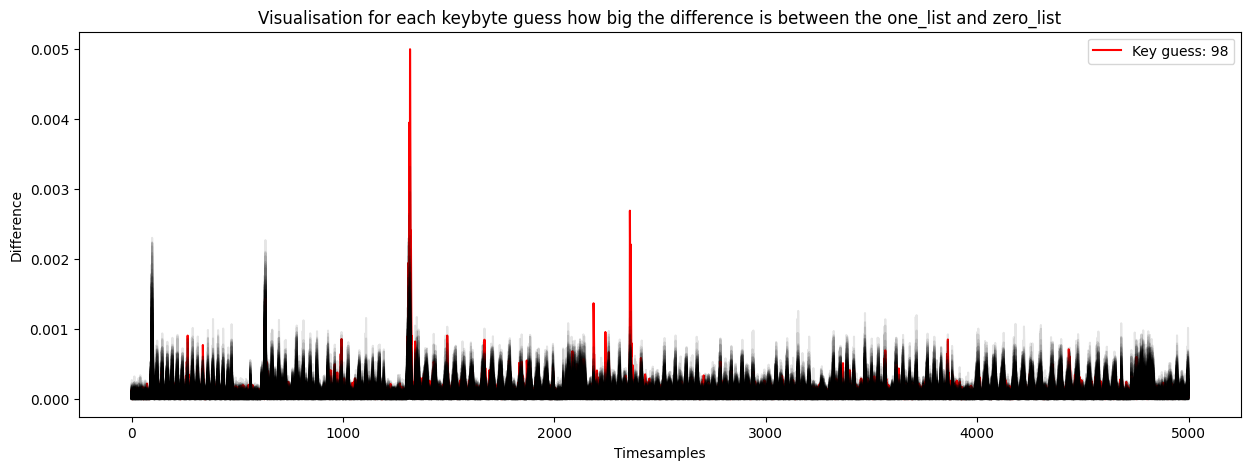

In [148]:
plt.figure(figsize=(15, 5))

for keybyte_guess, diff_average_trace in enumerate(diff_average_traces):
    if keybyte_guess == correct_key[target_byte]: # Check if the key guess is the correct key
        plt.plot(diff_average_trace, color = 'r', label = "Key guess: " + str(keybyte_guess))
    else:
        plt.plot(diff_average_trace, color='k',alpha=0.1)

plt.ylabel("Difference")
plt.xlabel("Timesamples")
plt.title("Visualisation for each keybyte guess how big the difference is between the one_list and zero_list")
plt.legend()
plt.show()

If you have done the sorting correctly, you'll notice a large peak. This is the point in our power trace where our sensitive variable is being computed and used. For each ```average_trace```, select select the highest absolute value and add those to our earlier generated ```list_difference_of_means```. Find the key guess which has the biggest difference. What is the correct key byte?

What we are doing:
- for each 256 possible key values of the byte
    - divide the traces in two groups based on the chosen bit of the sensitive values
    - if key byte is correct, the groups should be correct and the difference between their averages should highlight a big difference in power usage, where the key bit is operated on

In [150]:
for diff_average_trace in diff_average_traces:
    # Find the highest difference point in our average trace
    peak = diff_average_trace.max()
    # Add the largest difference point to our list_difference_of_means
    list_difference_of_means.append(peak)
    

predicted_keybyte = np.argmax(list_difference_of_means)
print("Predicted keybyte: " +str(predicted_keybyte))
print("Correct keybyte: " + str(correct_key[target_byte]))

Predicted keybyte: 98
Correct keybyte: 98


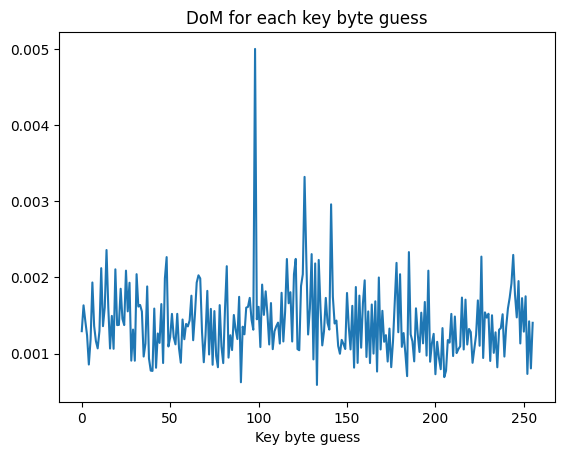

In [151]:
plt.plot(list_difference_of_means)
plt.title("DoM for each key byte guess")
plt.xlabel("Key byte guess")
plt.show()

### 2.5 - Iterate over target bytes and keybyte guesses

Now, you are able to compute the correct keybyte for one target byte. Use the same methodology as before to recover the whole AES-key. Complete the code snippet below and answer the questions in the PDF document.

In [152]:
nr_AES_bytes = 16
nr_keybyte_guesses = 256
recovered_key = []

# Write loop to attack target bytes one by one.
for target_byte in tnrange(nr_AES_bytes):
    diff_average_traces = np.zeros((nr_keybyte_guesses, nr_samples))

    # For each keybyte, try out every different key hypothesis
    for keybyte_guess in tnrange(nr_keybyte_guesses):
        one_list = []
        zero_list = []
        for trace, plaintext in zip(traces, plaintexts):
            y = intermediate_variable(plaintext[target_byte], keybyte_guess)
            y_targetbit = format(y, '08b')[specific_bit]
            if y_targetbit == "1":
                one_list.append(trace)
            else:
                zero_list.append(trace)
        
        # compute for each list, the average power trace
        average_list_zero = np.array(zero_list).mean(axis=0)
        average_list_one = np.array(one_list).mean(axis=0)

        difference_between_average_traces = np.array(np.abs(average_list_zero - average_list_one))
        diff_average_traces[keybyte_guess]= difference_between_average_traces

    list_difference_of_means = [] # Empty array to use later

    for diff_average_trace in diff_average_traces:
        
        peak = diff_average_trace.max()
        # Add the largest difference point to our list_difference_of_means
        list_difference_of_means.append(peak)
       

    correct_keybyte_guess = np.argmax(list_difference_of_means)
    recovered_key.append(int(correct_keybyte_guess))
    print(correct_keybyte_guess)


print("Recovered key: " + str(recovered_key))
print("Correct key: " + str(correct_key))

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

98


  0%|          | 0/256 [00:00<?, ?it/s]

1


  0%|          | 0/256 [00:00<?, ?it/s]

132


  0%|          | 0/256 [00:00<?, ?it/s]

82


  0%|          | 0/256 [00:00<?, ?it/s]

48


  0%|          | 0/256 [00:00<?, ?it/s]

200


  0%|          | 0/256 [00:00<?, ?it/s]

76


  0%|          | 0/256 [00:00<?, ?it/s]

179


  0%|          | 0/256 [00:00<?, ?it/s]

58


  0%|          | 0/256 [00:00<?, ?it/s]

191


  0%|          | 0/256 [00:00<?, ?it/s]

49


  0%|          | 0/256 [00:00<?, ?it/s]

193


  0%|          | 0/256 [00:00<?, ?it/s]

143


  0%|          | 0/256 [00:00<?, ?it/s]

15


  0%|          | 0/256 [00:00<?, ?it/s]

210


  0%|          | 0/256 [00:00<?, ?it/s]

53
Recovered key: [98, 1, 132, 82, 48, 200, 76, 179, 58, 191, 49, 193, 143, 15, 210, 53]
Correct key: [ 98   1 132  82  48 200  76 179  58 191  49 193 143  15 210  53]


## 3 - DPA attack with 1-bit and 2-bit leakage models and CPA as distinguisher
Now that you have completed attacking AES implementation using the DPA with 1-bit leakage model and DoM as the distinguisher, you are ready to try different leakage models and distinguishers. 

In this section, you will attack the same AES implementation, but now we specifically target the least-significant bit (LSB) and use correlation to distinguish between power traces. You only have to attack one target byte.



### 3.1 - Prediction matrix
In section 2, we did the estimation of the sensitive intermediate value on the fly for every keybyte guess and powertrace/plaintext set. But we can prepare these intermediate beforehand as well, and then later use different leakage models. 

We are going to create a prediction matrix, where we fill all our possible hypothetical values for $y$ in a matrix for each trace. For this assignment, we will target the third byte. What will be the size of our prediction matrix?

In [ ]:
# Build a prediction matrix that collects the output of the S-Box for all key hypotheses and the plaintext.
nr_keybyte_guesses = 256
target_byte = 2

prediction_matrix = np.zeros(shape=(nr_traces, nr_keybyte_guesses), dtype=int)

# TODO why was the trace given here??
for i, (trace, plaintext) in enumerate(zip(traces, plaintexts)):
    for keybyte_guess in range(nr_keybyte_guesses):
        v = intermediate_variable(plaintext[target_byte], keybyte_guess)
        prediction_matrix[i, keybyte_guess] = v

print(prediction_matrix)
print("Shape of prediction_matrix:", prediction_matrix.shape)  

[[ 15  45 153 ... 111 107 242]
 [168 159  60 ...  79 129  96]
 [140 161 137 ... 215 171 118]
 ...
 [ 99 124 119 ...  84 187  22]
 [174   8 101 ...  26   9 131]
 [166  28 198 ...   7 226 128]]
Shape of prediction_matrix: (2500, 256)


### 3.2 - Perform CPA with 1-bit least siginificant bit (LSB) leakage model

For every trace/plaintext combination, we now have the intermediate values precalculated for every keybyte guess. From here, we can easily index the intermediate value out of our prediction matrix when we are targeting our leaking bit. Let's create an array ```labels``` where we put the bit value for every keybyte hypothesis.

Complete the code snippet below. Calculate the hypothetical value for our target bit given a trace number and a certain keybyte.

In [197]:
def calculate_LSB_leakage(trace_nr, keybyte_guess, target_bit):
    bit_value_hypothesis = (int(prediction_matrix[trace_nr, keybyte_guess]) >> target_bit) & 1
    return bit_value_hypothesis

In [210]:
for i, bit in enumerate(bin(147)[2:][::-1]):
    assert calculate_LSB_leakage(0,0,i) == int(bit)

Complete the code snippet below. For every trace, we need to calculate all the possible hypothetical intermediate values for our target bit. Save those values to the ```labels``` array. 

In [264]:
# Do the computation of specific bit for all keybyte guesses
labels = np.zeros(shape=(nr_traces, nr_keybyte_guesses))

target_LSB = 7

for i, trace in enumerate(traces):
    for keybyte_guess in range(nr_keybyte_guesses):
        lsb_hypothesis = calculate_LSB_leakage(i, keybyte_guess, target_LSB)
        labels[i, keybyte_guess] = lsb_hypothesis

Now, we can start correlating our hypothetical values to our power traces. Let's first create an array where we can store the correlation values. Which shape will this array have?

In [265]:
# correlate each keyguess column with each trace
corr_traces_keyguesses = np.zeros(shape=(nr_keybyte_guesses, nr_samples))
print("Correlation array between traces and key guesses = ", corr_traces_keyguesses.shape)
print("Traces = ", traces.shape)
print(labels.shape)

Correlation array between traces and key guesses =  (256, 5000)
Traces =  (2500, 5000)
(2500, 256)


It is time to compute the correlation between our power traces and hypothetical intermediate values. Store all correlation coefficients in the array we created earlier.

In [266]:
# Perform correlation analysis
for key_guess in tnrange(nr_keybyte_guesses):
    hypothesis = labels[:, key_guess]
    for sample in range(nr_samples):
        r = pearsonr(hypothesis, traces[:, sample]).correlation
        corr_traces_keyguesses[key_guess, sample] = r

  0%|          | 0/256 [00:00<?, ?it/s]

We now have for each keybyte guess (how much power it might use using some LSB of sensitive value), how much it correlates with the samples at i.

For the correct keybyte guess, it should correlate very high at certain sample points, where the key computed on

In [274]:
abs_corr_traces_keyguesses = np.abs(corr_traces_keyguesses)

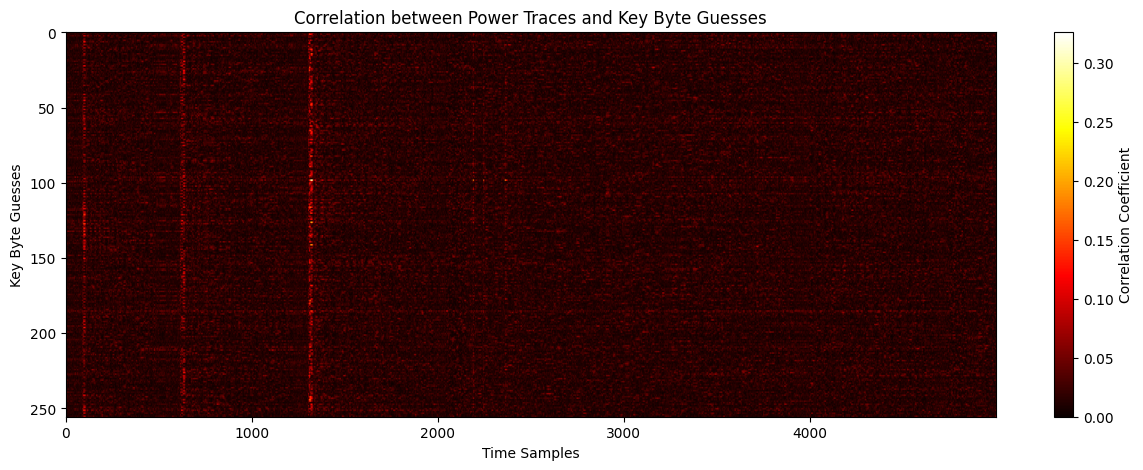

In [275]:
plt.figure(figsize=(15, 5))
plt.imshow(abs_corr_traces_keyguesses, aspect='auto', cmap='hot')
plt.colorbar(label='Correlation Coefficient')
plt.xlabel('Time Samples')
plt.ylabel('Key Byte Guesses')
plt.title('Correlation between Power Traces and Key Byte Guesses')
plt.show()

In the case where our correlation is the strongest, this is most likely the correct hypothetical intermediate value, and thus the correct keybyte guess. Find the strongest correlation in our correlation array. Which key guess belongs to this value?

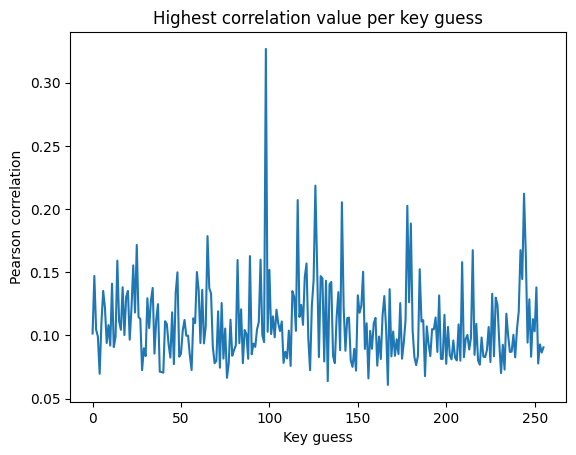

In [283]:
plt.plot(abs_corr_traces_keyguesses.max(axis=1))
plt.title("Highest correlation value per key guess")
plt.xlabel("Key guess")
plt.ylabel("Pearson correlation")
plt.show()

In [ ]:
highest_corr = abs_corr_traces_keyguesses.flatten().max()
best_keyguess = abs_corr_traces_keyguesses.max(axis=1).argmax()
sample_idx = abs_corr_traces_keyguesses.max(axis=0).argmax()

print("Correct keybyte:", correct_key[target_byte])
print("Highest correlating keybyte guess:", best_keyguess)
print("Correlation value: ", highest_corr)
print("Peak sample index:", sample_idx)

correlation_array_LSB = abs_corr_traces_keyguesses[best_keyguess]

Correct keybyte: 98
Highest correlating keybyte guess: 98
Correlation value:  0.32665240151278774
Peak sample index: 1317


Just like earlier, plot the correlation for each key guess below. Highlight the correlation for the correct key guess.

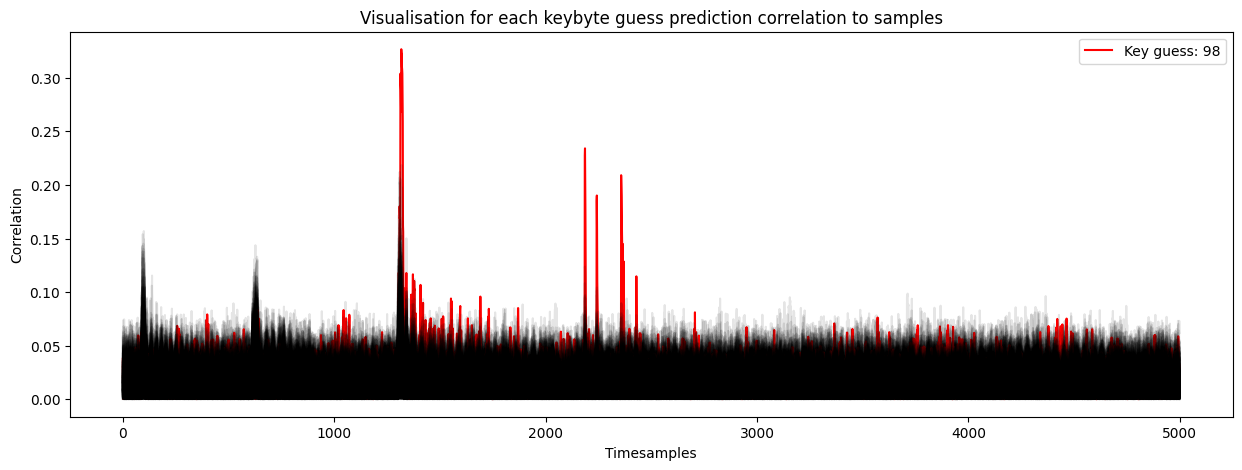

In [280]:
plt.figure(figsize=(15, 5))

for keybyte_guess, trace_correlation in enumerate(abs_corr_traces_keyguesses):
    if keybyte_guess == correct_key[target_byte]:  # Check if the key guess is the correct key
        plt.plot(trace_correlation, color="r", label="Key guess: " + str(keybyte_guess))
    else:
        plt.plot(trace_correlation, color="k", alpha=0.1)

plt.ylabel("Correlation")
plt.xlabel("Timesamples")
plt.title("Visualisation for each keybyte guess prediction correlation to samples")
plt.legend()
plt.show()

### 3.3 - Perform CPA with 2-bit LSB and second LSB as leakage model

We can incoorperate the leakage of two bytes, in order to capture more information. We are going to perform the same attack, but now use the least significant bit (LSB) and second least significant bit (SLSB) to model the leakage. 

Complete the code snippet below.

In [292]:
def calculate_2LSB_leakage(trace_nr, keybyte_guess, SLSB, LSB): 
    first = calculate_LSB_leakage(trace_nr, keybyte_guess, LSB)
    second = calculate_LSB_leakage(trace_nr, keybyte_guess, SLSB)
    bit_value_hypothesis = (second << 1) | first
    return bit_value_hypothesis


Now, compute the labels belonging to our power traces.

In [293]:
# Do the computation of specific bit for all keybyte guesses
labels = np.zeros(shape=(nr_traces, nr_keybyte_guesses))

target_LSB = 7
target_SLSB = 6

# Create labels here
for i, trace in enumerate(traces):
    for keybyte_guess in range(nr_keybyte_guesses):
        lsb_hypothesis = calculate_2LSB_leakage(i, keybyte_guess, target_SLSB, target_LSB)
        labels[i, keybyte_guess] = lsb_hypothesis

And correlate our labels to the power traces!

In [301]:
corr_traces_keyguesses = np.zeros(shape=(nr_keybyte_guesses, nr_samples))

for key_guess in tnrange(nr_keybyte_guesses):
    hypothesis = labels[:, key_guess]
    for sample in range(nr_samples):
        r = pearsonr(hypothesis, traces[:, sample]).correlation
        corr_traces_keyguesses[key_guess, sample] = r

  0%|          | 0/256 [00:00<?, ?it/s]

In [ ]:
abs_corr_traces_keyguesses = np.abs(corr_traces_keyguesses)

In [320]:

highest_corr = abs_corr_traces_keyguesses.max()
best_keyguess = abs_corr_traces_keyguesses.max(axis=1).argmax()
sample_idx = abs_corr_traces_keyguesses.max(axis=0).argmax()

print("Correct keybyte:", correct_key[target_byte])
print("Highest correlating keybyte guess:", best_keyguess)
print("Correlation value: ", highest_corr)
print("Peak sample index:", sample_idx)


correlation_array_SLSB = abs_corr_traces_keyguesses[best_keyguess]

Correct keybyte: 98
Highest correlating keybyte guess: 98
Correlation value:  0.45372751205845285
Peak sample index: 1313


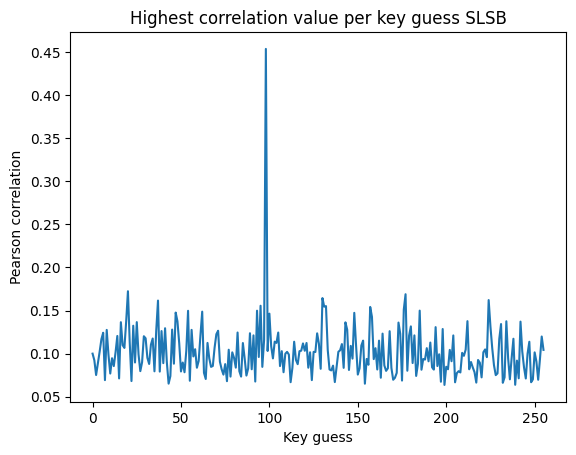

In [333]:
plt.plot(abs_corr_traces_keyguesses.max(axis=1))
plt.title("Highest correlation value per key guess SLSB")
plt.xlabel("Key guess")
plt.ylabel("Pearson correlation")
plt.show()

Make a plot with the correlation of the correct key for the 1-bit and 2-bit model, which are saved in ```correlation_array_LSB``` and ```correlation_array_SLSB```  Which model has a higher peak? Why do you think this is the case?

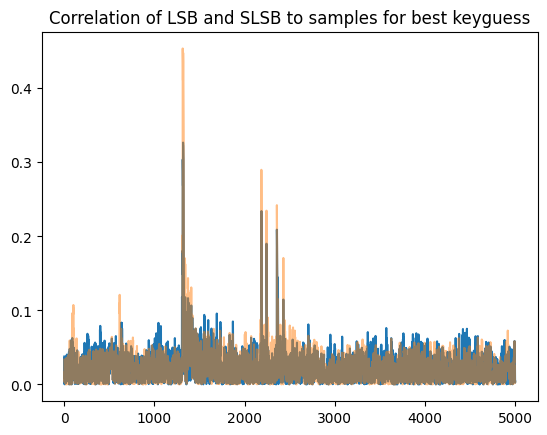

In [332]:
fig = plt.figure()
plt.plot(correlation_array_LSB)
plt.plot(correlation_array_SLSB, alpha=0.5)
plt.title("Correlation of LSB and SLSB to samples for best keyguess")
plt.show()

## 4 - End of tutorial

You have reached the end of the tutorial. Now you should be able to perform DPA attacks with various leakage models and distinguishers. Go back to the tutorial pdf and answer the questions.

If you have any other questions, feel free to contact the TA's!